In [10]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [11]:
class BasicMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(BasicMessagePassing, self).__init__(aggr='add')  # Use sum aggregation
        self.lin = nn.Linear(in_channels, out_channels)
        self.update_mlp = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )

    def forward(self, x, edge_index):
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.lin(x)
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j, x_i):
        return x_j - x_i
    
    def update(self, aggr_out, x):
        return self.update_mlp(aggr_out) + x



class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.conv1 = GCNConv(latent_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class GAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_dim_lin):
        super(GAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        self.lin1 = Linear(latent_dim, hidden_dim_lin)
        self.lin2 = Linear(hidden_dim_lin, hidden_dim_lin)
        self.lin3 = Linear(hidden_dim_lin, hidden_dim_lin)
        self.lin4 = Linear(hidden_dim_lin, hidden_dim_lin)
        self.lin = Linear(hidden_dim_lin, 2)

    def forward(self, data, batch=None):
        x, edge_index, pos = data.x, data.edge_index, data.pos
        edge_weight = calculate_edge_weights(pos, edge_index)
        z = self.encoder(x, edge_index, edge_weight)
        recon_x = self.decoder(z, edge_index, edge_weight)
        y = F.relu(self.lin1(global_mean_pool(z, batch)))
        y1 = F.relu(self.lin2(y))
        y2 = F.relu(self.lin3(y1))
        y3 = F.relu(self.lin4(y2)) + y1         
        y = self.lin(y3)
        return recon_x, y

# Calculate Euclidean distances as edge weights
def calculate_edge_weights(pos, edge_index):
    row, col = edge_index
    distances = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return distances


In [12]:
train_loader = torch.load(r'C:\Users\Rohit\Documents\Projects\data\MLgSA\train_loader.pt')
test_loader = torch.load(r'C:\Users\Rohit\Documents\Projects\data\MLgSA\test_loader.pt')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on: ', device)

Running on:  cuda


In [14]:
model = GAE(input_dim=1, hidden_dim=16, latent_dim=8, hidden_dim_lin=25).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.7])).to(device)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=.1, end_factor=1e-3, total_iters=100)
train_losses = []
test_losses = []
test_accu = []

In [15]:
for epoch in range(1, 100 + 1):
        # Train Phase
        run_loss = 0.
        iters = 0
        model.train()
        eval_loss = 0.
        for graph in train_loader:
            graph.to(device)
            optimizer.zero_grad()
            out, out_y = model(graph)
            loss = 0.05 * criterion(out, graph.x) + loss_fn(out_y, graph.y)
            loss.backward()
            #for name, param in model.named_parameters():
            #    print(name, param.grad)
            optimizer.step()
            
            run_loss += loss.item()
            iters += 1
        train_losses.append(run_loss/iters)


        # Eval Phase
        eval_iters = 0
        model.eval()
        accs = []
        for graph in test_loader:
            graph.to(device)
            out, out_y = model(graph)
            loss = loss_fn(out_y, graph.y)
            eval_loss += loss.item()
            eval_iters += 1
            accs.append((out_y.argmax()==graph.y).item())
        test_accu.append(np.sum(accs) / len(accs))
        test_losses.append(eval_loss/eval_iters)

        scheduler.step()

        if epoch % 10 == 0: 
            show_info = '\nEpoch: {} -- Train: {}, Loss: {}, \
                Accuracy: {}'.format(epoch, train_losses[-1], test_losses[-1], \
                                    test_accu[-1] )
            print(show_info)



Epoch: 10 -- Train: 0.5484472180427122, Loss: 0.505391801148653,                 Accuracy: 0.7

Epoch: 20 -- Train: 0.4944985889430557, Loss: 0.41568921487778426,                 Accuracy: 0.85

Epoch: 30 -- Train: 0.4933073674680806, Loss: 0.4136721733957529,                 Accuracy: 0.825

Epoch: 40 -- Train: 0.4784512171099166, Loss: 0.4087766885757446,                 Accuracy: 0.85

Epoch: 50 -- Train: 0.4771045640486629, Loss: 0.41523851938545703,                 Accuracy: 0.85

Epoch: 60 -- Train: 0.4655590605835955, Loss: 0.41144739016890525,                 Accuracy: 0.85

Epoch: 70 -- Train: 0.46673283769803886, Loss: 0.4125945698469877,                 Accuracy: 0.85

Epoch: 80 -- Train: 0.46633760944134045, Loss: 0.4114256415516138,                 Accuracy: 0.85

Epoch: 90 -- Train: 0.45909780564428376, Loss: 0.41179285421967504,                 Accuracy: 0.85

Epoch: 100 -- Train: 0.45717194125431926, Loss: 0.41248394884169104,                 Accuracy: 0.85


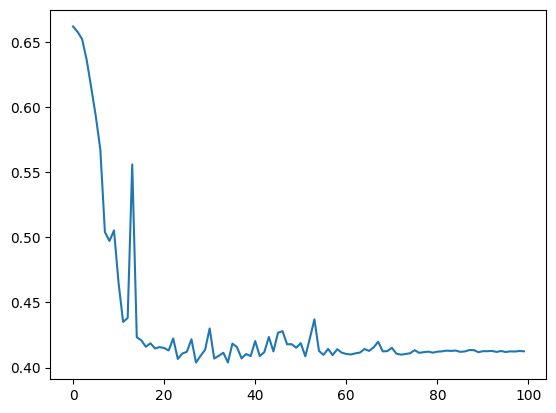

In [16]:
plt.plot(test_losses)

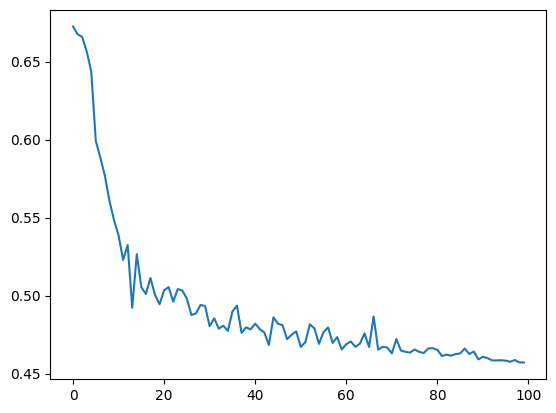

In [17]:
plt.plot(train_losses)

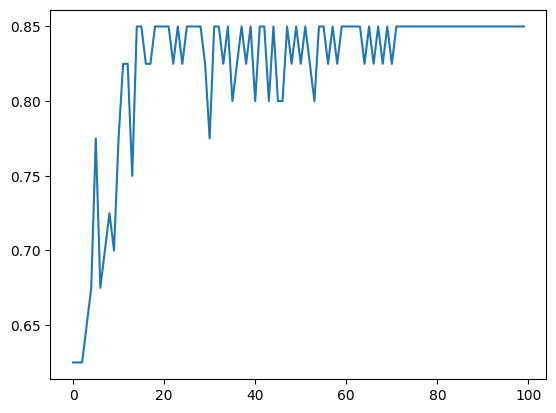

In [19]:
plt.plot(test_accu)

In [20]:
import numpy as np
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "./states")

np.savetxt('train_log.npy', np.asarray(train_losses))
np.savetxt('test_log.npy', np.asarray(test_losses))